In [1]:
import os
import torch
import sys
import pandas as pd
import numpy as np
import re
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA
parent_dir = os.path.abspath("..")
sys.path.append(parent_dir)


from src.classifying import (
    ActivationsHandler,
    get_correctness_direction_classifier
)

def extract_number(filename):
    match = re.search(r'\d+', filename)
    return int(match.group()) if match else -1

In [10]:
model = "mistral_7b_instruct"
train_dataset = "trivia_qa_2_60k"
test_dataset = "birth_years_4k"

activations_train_path = "/home/arnau/Desktop/Cambridge/MARS/correctness-model-internals/activations/raw/" + model + "/" + train_dataset + "/base/main/prompt_only/layer_20"  
activation_train_files = sorted([f for f in os.listdir(activations_train_path) if f.endswith(".pt")], key=extract_number)
activations_train_list = [torch.load(os.path.join(activations_train_path, f), map_location='cpu').cpu() for f in activation_train_files]
activations_train_raw = torch.cat(activations_train_list, dim=0)
activations_test_path = "/home/arnau/Desktop/Cambridge/MARS/correctness-model-internals/activations/raw/" + model + "/" + test_dataset + "/base/main/prompt_only/layer_20"  
activation_test_files = sorted([f for f in os.listdir(activations_test_path) if f.endswith(".pt")], key=extract_number)
activations_test_list = [torch.load(os.path.join(activations_test_path, f), map_location='cpu').cpu() for f in activation_test_files]
activations_test_raw = torch.cat(activations_test_list, dim=0)
df_train = pd.read_csv("/home/arnau/Desktop/Cambridge/MARS/correctness-model-internals/evaluations/" + model + "/" + train_dataset + "/base/main_generations_evaluated.csv")
labels_train = df_train["correct"].to_numpy()
df_test = pd.read_csv("/home/arnau/Desktop/Cambridge/MARS/correctness-model-internals/evaluations/" + model + "/" + test_dataset + "/base/main_generations_evaluated.csv")
labels_test = df_test["correct"].to_numpy()
prompts_raw_train = df_train["prompt"].to_numpy()
prompts_raw_test = df_test["prompt"].to_numpy()
#prompts_train = [prompt[483:-8] for prompt in prompts_raw_train]
prompts_train = [prompt[527:-8] for prompt in prompts_raw_train]
#prompts_test = [prompt[346:-8] for prompt in prompts_raw_test]
prompts_test = [prompt[390:-8] for prompt in prompts_raw_test]
answers_train = df_train["answer"].to_numpy()
answers_test = df_test["answer"].to_numpy()
ground_truth_train = df_train["ground_truth"].to_numpy()
ground_truth_test = df_test["ground_truth"].to_numpy()
idk_test = df_test["idk_response"].to_numpy()

In [3]:
print("Train")
print("Correct:", sum(labels_train))
print("Incorrect:", len(labels_train) - sum(labels_train))
print("Total labels:", len(labels_train))
print("Percentage correct:", (sum(labels_train) / len(labels_train)) * 100)
print("Test")
print("Correct:", sum(labels_test))
print("Incorrect:", len(labels_test) - sum(labels_test))
print("Total labels:", len(labels_test))
print("Percentage correct:", (sum(labels_test) / len(labels_test)) * 100)

Train
Correct: 48962
Incorrect: 9584
Total labels: 58546
Percentage correct: 83.62996618043931
Test
Correct: 3078
Incorrect: 1352
Total labels: 4430
Percentage correct: 69.48081264108352


In [4]:
train_size = 9500
indices_correct_train = [i for i, x in enumerate(labels_train) if x == 1][:train_size]
indices_incorrect_train = [i for i, x in enumerate(labels_train) if x == 0][:train_size]
indices_train = indices_correct_train + indices_incorrect_train
activations_train = activations_train_raw[indices_train]
labels_train = torch.tensor(np.array([1 if idx in set(indices_correct_train) else 0 for idx in indices_train]), dtype=torch.bool)

test_size = 1300
indices_correct_test = [i for i, x in enumerate(labels_test) if x == 1][:test_size]
indices_incorrect_test = [i for i, x in enumerate(labels_test) if x == 0][:test_size]
indices_test = indices_correct_test + indices_incorrect_test
activations_test = activations_test_raw[indices_test]
labels_test = torch.tensor(np.array([1 if idx in set(indices_correct_test) else 0 for idx in indices_test]), dtype=torch.bool)

In [11]:
idk_test

array([False, False, False, ..., False, False, False])

In [ ]:
# given a list of indices, indices_test, and a vector of bools, idk_test, return a vector of bools of size len(indices_test) that contains true if the corresponding index in idk_test is true


In [5]:
activations_handler_train = ActivationsHandler(
  activations=activations_train, # torch tensor of [batch, activations]
  labels=labels_train, # each row label should correspond to the row in activations_tensor
)

activations_handler_test = ActivationsHandler(
  activations=activations_test, # torch tensor of [batch, activations]
  labels=labels_test, # each row label should correspond to the row in activations_tensor
)

direction_classifier, direction_calculator = get_correctness_direction_classifier(
  activations_handler_train=activations_handler_train,
  activations_handler_test=activations_handler_test,
)

In [6]:
direction_classifier.classification_metrics

{'optimal_cut': -0.12102754414081573,
 'optimal_train_set_cut': -0.12102754414081573,
 'test_roc_auc': 0.8844396449704142,
 'accuracy_score': 0.5,
 'f1_score': 0.6666666666666666,
 'precision_score': 0.5,
 'recall_score': 1.0}

<Figure size 1000x500 with 0 Axes>

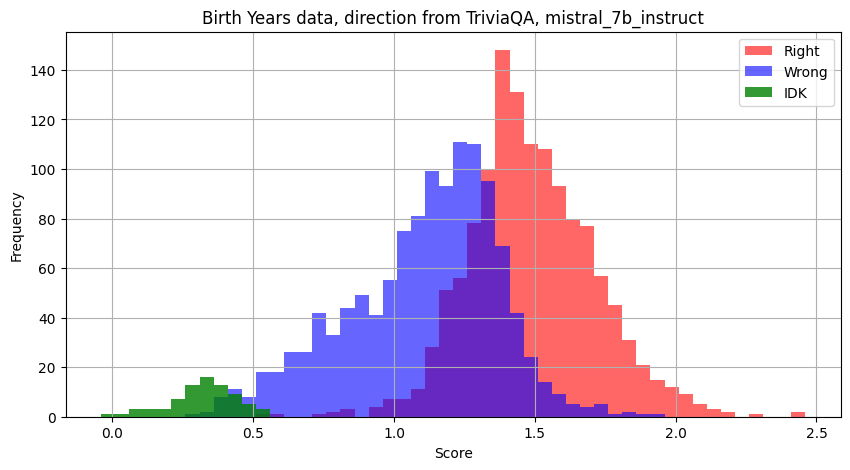

In [ ]:
test_scores = direction_classifier.test_classification_score
test_classes = direction_classifier.test_labels
idk_labels = []
for idx in indices_test:
    idk_labels.append(idk_test[idx])
# convert to pd.Series
idk_labels = pd.Series(idk_labels)

# Extract scores for each class
class_0_scores = test_scores[test_classes == 1].numpy()
class_1_scores = test_scores[(test_classes == 0) & (idk_labels == 0)].numpy()
class_2_scores = test_scores[(test_classes == 0) & (idk_labels == 1)].numpy()

# Plot distributions
plt.figure(figsize=(10, 5))
num_bins = 50  # You can adjust the number of bins
bins = np.linspace(test_scores.min(), test_scores.max(), num_bins + 1)

# Plot with uniform bins
plt.figure(figsize=(10, 5))
plt.hist(class_0_scores, bins=bins, alpha=0.6, color='red', label='Right')
plt.hist(class_1_scores, bins=bins, alpha=0.6, color='blue', label='Wrong')
plt.hist(class_2_scores, bins=bins, alpha=0.8, color='green', label='IDK')

plt.xlabel('Score')
plt.ylabel('Frequency')
plt.title('Birth Years data, direction from TriviaQA, mistral_7b_instruct')
plt.legend()
plt.grid()
plt.show()
plt.legend()

### cities

In [37]:
test_dataset = "cities_10k"
model = "mistral_7b_instruct"
activations_test_path = "/home/arnau/Desktop/Cambridge/MARS/correctness-model-internals/activations/raw/" + model + "/" + test_dataset + "/base/main/prompt_only/layer_20"  
activation_test_files = sorted([f for f in os.listdir(activations_test_path) if f.endswith(".pt")], key=extract_number)
activations_test_list = [torch.load(os.path.join(activations_test_path, f), map_location='cpu').cpu() for f in activation_test_files]
activations_test_raw = torch.cat(activations_test_list, dim=0)
df_test = pd.read_csv("/home/arnau/Desktop/Cambridge/MARS/correctness-model-internals/evaluations/" + model + "/" + test_dataset + "/base/main_generations_evaluated.csv")
labels_test = df_test["correct"].to_numpy()
idk_test = df_test["idk_response"].to_numpy()
train_size = 9500
indices_correct_train = [i for i, x in enumerate(labels_train) if x == 1][:train_size]
indices_incorrect_train = [i for i, x in enumerate(labels_train) if x == 0][:train_size]
indices_train = indices_correct_train + indices_incorrect_train
activations_train = activations_train_raw[indices_train]
labels_train = torch.tensor(np.array([1 if idx in set(indices_correct_train) else 0 for idx in indices_train]), dtype=torch.bool)

In [38]:
activations_handler_train = ActivationsHandler(
  activations=activations_train, # torch tensor of [batch, activations]
  labels=labels_train, # each row label should correspond to the row in activations_tensor
)
activations_handler_test = ActivationsHandler(
  activations=activations_test_raw, # torch tensor of [batch, activations]
  labels=labels_test, # each row label should correspond to the row in activations_tensor
)
direction_classifier, direction_calculator = get_correctness_direction_classifier(
  activations_handler_train=activations_handler_train,
  activations_handler_test=activations_handler_test,
)

In [39]:
direction_classifier.classification_metrics

{'optimal_cut': -0.12102754414081573,
 'optimal_train_set_cut': -0.12102754414081573,
 'test_roc_auc': 0.890466065642306,
 'accuracy_score': 0.5186298076923077,
 'f1_score': 0.6559278350515464,
 'precision_score': 0.48806733432772215,
 'recall_score': 0.9997817546922741}

In [49]:
print(len(class_0_scores))
print(len(class_1_scores))
print(len(class_2_scores))

4582
1994
3408


<Figure size 1000x500 with 0 Axes>

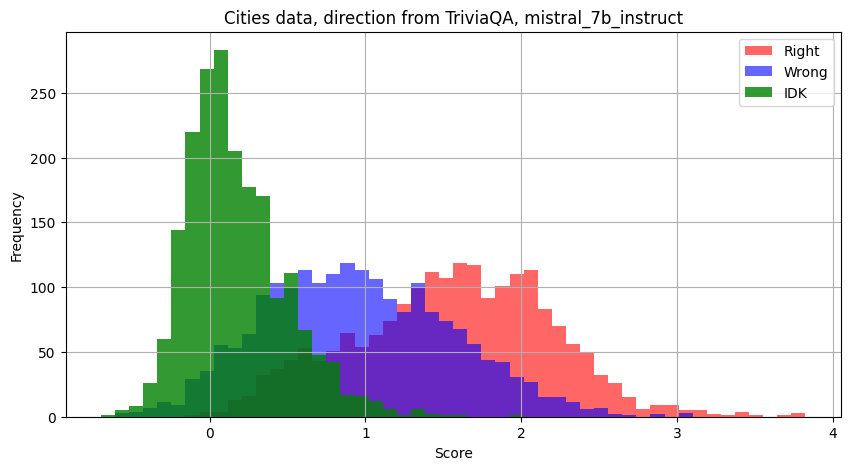

In [53]:
test_scores = direction_classifier.test_classification_score
test_classes = direction_classifier.test_labels
idk_labels = pd.Series(idk_test)

# Extract scores for each class
class_0_scores = test_scores[test_classes == 1].numpy()[:1990]
class_1_scores = test_scores[(test_classes == 0) & (idk_labels == 0)].numpy()[:1990]
class_2_scores = test_scores[(test_classes == 0) & (idk_labels == 1)].numpy()[:1990]

# Plot distributions
plt.figure(figsize=(10, 5))
num_bins = 50  # You can adjust the number of bins
bins = np.linspace(test_scores.min(), test_scores.max(), num_bins + 1)

# Plot with uniform bins
plt.figure(figsize=(10, 5))
plt.hist(class_0_scores, bins=bins, alpha=0.6, color='red', label='Right')
plt.hist(class_1_scores, bins=bins, alpha=0.6, color='blue', label='Wrong')
plt.hist(class_2_scores, bins=bins, alpha=0.8, color='green', label='IDK')

plt.xlabel('Score')
plt.ylabel('Frequency')
plt.title('Cities data, direction from TriviaQA, mistral_7b_instruct')
plt.legend()
plt.grid()
plt.show()